### This notebook loads and train data from the directories without having them to load on memory

In [23]:
import os
os.chdir('C:\\Projects\\ature')
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np

import neuralnet.utils.data_utils as dutils
from commons.IMAGE import SegmentedImage
from PIL import Image as IMG
import utils.img_utils as imgutils

### Directories setup

In [24]:
sep = os.sep
Dirs = {}

Dirs['train_data']= 'data'+sep+'DRIVE'+sep+'training'+sep +'patches'
Dirs['test_data'] = 'data'+sep+'DRIVE'+sep+'test' +sep+ 'patches'
Dirs['checkpoint']   = 'data' +sep+ 'checkpoint'

Dirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'
Dirs['segmented'] = Dirs['data'] +sep+ 'drive_segmented'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
    
batch_size = 32
num_classes = 4
epochs = 4

### Define data sources

In [52]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True
)

validation_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

train_generator = train_datagen.flow_from_directory(
        Dirs['train_data'],
        target_size=(31, 31),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        Dirs['test_data'],
        target_size=(31, 31),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical', 
        seed=10)

test_generator = validation_datagen.flow_from_directory(
        Dirs['test_data'],
        target_size=(31, 31),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode=None, 
        seed=11,
        shuffle=False)

Found 62810 images belonging to 4 classes.
Found 9802 images belonging to 4 classes.
Found 9802 images belonging to 4 classes.


### Load training and test data: CAREFUL!!! Memory Intensive task

In [26]:
# x_train, y_train = dutils.load_dataset(data_path=Dirs['train_data'], img_shape=(31,31,1), num_classes=num_classes)
# x_test, y_test = dutils.load_dataset(data_path=Dirs['test_data'], img_shape=(31,31,1), num_classes=num_classes)

# class_weights = dutils.get_class_weights(y_train)

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# train_datagen.fit(x_train)
# test_datagen.fit(x_test)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

### Define model

In [28]:
model = Sequential() 

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(31,31,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [30]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Fit model from x_train and y_train

In [71]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              class_weight=class_weights)

### Fit model from directory generators

In [31]:
ci = train_generator.class_indices
class_weights = {ci['green']: 15, ci['red']: 7, ci['white']: 5. ci['black']: 1 }
model.fit_generator(
        train_generator,
        steps_per_epoch=10000,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800, verbose=1, class_weights=class_weights)

Epoch 1/1
2000/2000 [==============================] - 415s 207ms/step - loss: 0.2886 - acc: 0.9153 - val_loss: 0.3198 - val_acc: 0.9024


In [53]:
### If we shuffle, we wont be able to generate a segmented image.
test_generator.shuffle = False
prediction = model.predict_generator(test_generator)
pred = np.argmax(prediction, axis=1)

In [38]:
img_obj = SegmentedImage()
img_obj.load_file(data_dir=Dirs['images'], file_name='01_test.tif')
img_obj.working_arr = img_obj.image_arr[:, :, 1]

In [66]:
seg = np.zeros_like(img_obj.working_arr)

In [36]:
np.unique(pred, return_counts=True)

(array([0, 3], dtype=int64), array([7524, 2278], dtype=int64))

In [68]:
for ix, f in enumerate(test_generator.filenames):
    i,j = f.split('\\')[1].split(' ')[1].split('.')[0].split('_')
    if pred[ix]==ci['white'] or pred[ix]==ci['red']:
        seg[int(i),int(j)] = 255

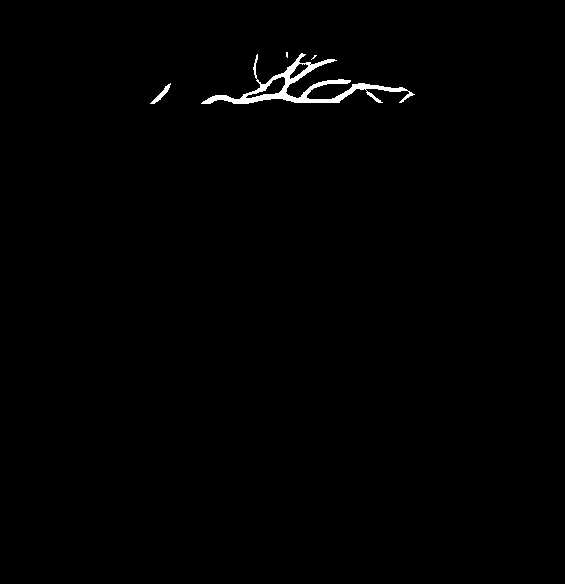

In [70]:
IMG.fromarray(seg)